In [1]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
import os
import numpy as np

0.24.1


In [2]:
from fracModel import fracOrdUU
from get_data import *

In [7]:
X, y = get_data("data2")

In [4]:
# #Graphs
# data = np.load("ica_data.npz")
# X = data["X"]
# y = data["y"]
# del data

In [8]:
print(X.shape)
print(y.shape)

(1265, 32, 513)
(1265,)


In [9]:
from collections import Counter
print(Counter(y).keys())
print(Counter(y).values())

dict_keys([0, 1, 2, 3])
dict_values([304, 328, 308, 325])


In [19]:
def get_current_set(X, y, start):
    X0 = X[10 + (10*start):20 + (10*start), :, :]
    y0 = y[10 + (10*start):20 + (10*start)]
    X1 = X[310 + (10*start):320 + (10*start), :, :]
    y1 = y[310 + (10*start):320 + (10*start)]
    X2 = X[650 + (10*start):660 + (10*start), :, :]
    y2 = y[650 + (10*start):660 + (10*start)]
    X3 = X[950 + (10*start):960 + (10*start), :, :]
    y3 = y[950 + (10*start):960 + (10*start)]
    Xs = np.concatenate([X0, X1, X2, X3], axis = 0)
    ys = np.concatenate([y0, y1, y2, y3], axis = 0)
    return (Xs, ys)

#### Parameterization

In [12]:
def get_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1, niter = 5)
    fModel.fit(X)
    
    return fModel._AMat[-1]

In [22]:
for i in range(20):
    already = 21
    j = i+already
    print("Batch no.: ", j)
    tu = get_current_set(X, y, j)
    Xs = tu[0]
    ys = tu[1]
    Adata = np.stack([get_A(x) for x in Xs])
    np.savez("Xbatch{}".format(j), Adata = Adata, Y = ys)

Batch no.:  21
beginning mse = 45.321956
iter ind = 0, mse = 21.613709
iter ind = 1, mse = 18.590497
iter ind = 2, mse = 19.835975
iter ind = 3, mse = 14.233167
iter ind = 4, mse = 37.856910
time taken = 33.057123
beginning mse = 34.611420
iter ind = 0, mse = 4.671324
iter ind = 1, mse = 3.576299
iter ind = 2, mse = 8.220356
iter ind = 3, mse = 10.926252
iter ind = 4, mse = 8.159582
time taken = 29.952999
beginning mse = 33.246845
iter ind = 0, mse = 9.617952
iter ind = 1, mse = 12.454027
iter ind = 2, mse = 21.203983
iter ind = 3, mse = 37.068139
iter ind = 4, mse = 37.907346
time taken = 33.009371
beginning mse = 42.995720
iter ind = 0, mse = 26.225801
iter ind = 1, mse = 75.592700
iter ind = 2, mse = 201.515064
iter ind = 3, mse = 1131.161668
iter ind = 4, mse = 1092.071392
time taken = 38.414413
beginning mse = 91.805178
iter ind = 0, mse = 70.386142
iter ind = 1, mse = 193.114765
iter ind = 2, mse = 1242.464290
iter ind = 3, mse = 4296.910090
iter ind = 4, mse = 8114.910645
time t

KeyboardInterrupt: 

In [16]:
# If you wish to save your data
np.savez('Xs.npz', Adata = Adata, Y = ys)

In [27]:
del X
del y

### Loading the data

In [138]:
import glob
# for file in glob.glob(str("Xbatch*")):
#     data = np.load(file)
#     X.append(data["Adata"])
#     y.append(data["Y"])
X = np.vstack([np.load(file)["Adata"] for file in glob.glob(str("Xbatch*"))])
y = np.vstack([np.load(file)["Y"].reshape(40, 1) for file in glob.glob(str("Xbatch*"))])
print(X.shape)
print(y.shape)

(1120, 32, 32)
(1120, 1)


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

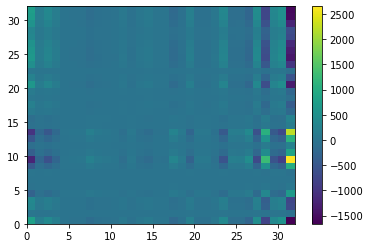

In [141]:
fig = plt.figure()
f = plt.pcolormesh(X[0])
plt.colorbar(f)

In [145]:
X = X*(1e-2)

In [146]:
cX = []
cy = []

In [147]:
for i in range(len(X)):
    if not (np.max(X[i])>10 or np.min(X[i])<-10):
        cX.append(X[i])
        cy.append(y[i])

In [149]:
len(cX)

845

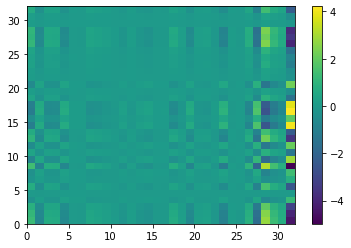

In [148]:
fig = plt.figure()
f = plt.pcolormesh(cX[0])
plt.colorbar(f)

## Applying ML

In [150]:
X = np.stack([np.concatenate([b for b in a]) for a in cX])

In [151]:
X.shape

(845, 1024)

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, cy, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [156]:
from sklearn.linear_model import LogisticRegression
Logclassifier = LogisticRegression(random_state = 0, max_iter= 1000)
Logclassifier.fit(X_train, y_train)

D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(max_iter=1000, random_state=0)

In [157]:
y_pred_log = Logclassifier.predict(X_test)

In [158]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

[[27 14  2  0]
 [ 0 40  0  7]
 [ 3 21  7  2]
 [ 1 36  1  8]]


In [159]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Logclassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  re

Accuracy: 46.16 %
Standard Deviation: 4.52 %


#### Kernal SVM

In [160]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'rbf', random_state = 0)
SVCclassifier.fit(X_train, y_train)

D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(random_state=0)

In [161]:
y_pred_SVC = SVCclassifier.predict(X_test)

In [162]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_SVC)
print(cm)
accuracy_score(y_test, y_pred_SVC)

[[33  9  1  0]
 [ 2 45  0  0]
 [ 2  2 29  0]
 [ 2 43  0  1]]


0.6390532544378699

#### Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

C:\Users\sahil\AppData\Local\Temp/ipykernel_13292/3713301477.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFclassifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [164]:
y_pred_RF = RFclassifier.predict(X_test)

In [165]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_RF)
print(cm)
accuracy_score(y_test, y_pred_RF)

[[43  0  0  0]
 [ 1 40  0  6]
 [ 1  0 32  0]
 [ 0  6  1 39]]


0.9112426035502958

#### KNN

In [166]:
from sklearn.neighbors import KNeighborsClassifier
KNNclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNclassifier.fit(X_train, y_train)

D:\Softwares\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [167]:
y_pred_KNN = KNNclassifier.predict(X_test)

In [168]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_KNN)
print(cm)
accuracy_score(y_test, y_pred_KNN)

[[40  2  1  0]
 [ 0 47  0  0]
 [ 1  1 30  1]
 [ 0  6  0 40]]


0.9289940828402367

#### Naive Bayes

In [169]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

D:\Softwares\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

In [170]:
y_pred_NB = NBclassifier.predict(X_test)

In [171]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_NB)
print(cm)
accuracy_score(y_test, y_pred_NB)

[[41  2  0  0]
 [ 0 46  0  1]
 [ 0  0 33  0]
 [ 0 26  0 20]]


0.8284023668639053

In [172]:
#from sklearn.metrics import roc_curve, auc

In [173]:
# log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred_log)
# auc_log = auc(log_fpr, log_tpr)
# SVC_fpr, SVC_tpr, threshold = roc_curve(y_test, y_pred_SVC)
# auc_SVC = auc(SVC_fpr, SVC_tpr)
# RF_fpr, RF_tpr, threshold = roc_curve(y_test, y_pred_RF)
# auc_RF = auc(RF_fpr, RF_tpr)
# KNN_fpr, KNN_tpr, threshold = roc_curve(y_test, y_pred_KNN)
# auc_KNN = auc(KNN_fpr, KNN_tpr)
# NB_fpr, NB_tpr, threshold = roc_curve(y_test, y_pred_NB)
# auc_NB = auc(NB_fpr, NB_tpr)

# plt.figure()
# plt.plot(SVC_fpr, SVC_tpr, linestyle = '-', label = "Suport Vector Machine (auc = %0.3f)"%auc_SVC)
# plt.plot(log_fpr, log_tpr, linestyle = '-', label = "Logarithimic regression (auc = %0.3f)"%auc_log)
# plt.plot(RF_fpr, RF_tpr, linestyle = '-', label = "Random Forest (auc = %0.3f)"%auc_RF)
# #plt.plot(KNN_fpr, KNN_tpr, linestyle = '-', label = "K-Nearest Neighbors (auc = %0.3f)"%auc_KNN)
# plt.plot(NB_fpr, NB_tpr, linestyle = '-', label = "Naive Bayes (auc = %0.3f)"%auc_NB)

# plt.xlabel("False Postive Rate")
# plt.ylabel("True Positive Rate")

# plt.legend()
# plt.show()

#### MLP

In [174]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [175]:
import matplotlib.pyplot as plt

In [177]:
  
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [184]:
ip = tf.keras.Input(shape = 1024)
BN = tf.keras.layers.BatchNormalization()(ip)
dense1 = tf.keras.layers.Dense(units = 32, activation = "relu")(BN)
dense2 = tf.keras.layers.Dense(units = 32, activation = "relu")(dense1)
dense3 = tf.keras.layers.Dense(units = 16, activation = "relu")(dense2)
dense4 = tf.keras.layers.Dense(units = 8, activation = "relu")(dense3)
dense4 = tf.keras.layers.Dense(units = 4, activation = "sigmoid")(ip)

Model = tf.keras.models.Model(inputs = ip, outputs = dense4)
Model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 4100      
Total params: 4,100
Trainable params: 4,100
Non-trainable params: 0
_________________________________________________________________


In [185]:
Model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [186]:
history = Model.fit(X_train, y_train, epochs = 500, validation_data = (X_test, y_test))

Epoch 1/500
22/22 [==============================] - 0s 6ms/step - loss: 0.7087 - acc: 0.2618 - val_loss: 0.7121 - val_acc: 0.2130
Epoch 2/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6796 - acc: 0.3195 - val_loss: 0.7073 - val_acc: 0.3018
Epoch 3/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6632 - acc: 0.3595 - val_loss: 0.7061 - val_acc: 0.2781
Epoch 4/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6524 - acc: 0.4349 - val_loss: 0.7010 - val_acc: 0.3195
Epoch 5/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6421 - acc: 0.4896 - val_loss: 0.6938 - val_acc: 0.3491
Epoch 6/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6345 - acc: 0.5178 - val_loss: 0.6903 - val_acc: 0.3728
Epoch 7/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6270 - acc: 0.5385 - val_loss: 0.6855 - val_acc: 0.3964
Epoch 8/500
22/22 [==============================] - 0s 2ms/step - loss: 0.6183 - a

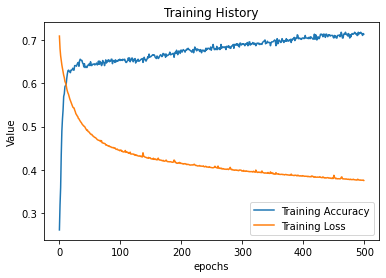

Initial training accuracy with preprocessing is:  0.2618343234062195
Final training accuracy with preprocessing is:  0.7130177617073059
Initial training loss with preprocessing is:  0.7086735367774963
Final training loss with preprocessing is:  0.3758050203323364


In [187]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

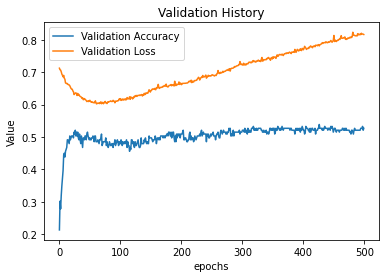

Initial Validation accuracy is:  0.21301774680614471
Best Validation accuracy is:  0.5384615659713745
Initial Validation loss is:  0.7120831608772278
Best Validation loss is:  0.6018757820129395


In [188]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))

In [200]:
inp_shape = (32, 32)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(32, 3,)(ip)
rel = tf.keras.layers.LeakyReLU()(conv1)
conv2 = tf.keras.layers.Conv1D(16, 3,)(rel)
rel2 = tf.keras.layers.LeakyReLU()(conv2)
# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(rel2)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
drop1 = tf.keras.layers.Dropout(.4)(leakyRelu)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(drop1)
leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.4)(dense2)
out = tf.keras.layers.Dense(4, activation = 'softmax')(drop2)

cnn = tf.keras.Model(inputs = ip, outputs = out)
cnn.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 32)            3104      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 30, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 16)            1552      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1436

In [201]:
cnn.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [202]:
history = cnn.fit(X_train.reshape(X_train.shape[0], 32, 32),y_train,epochs=100, validation_data = (X_test.reshape(X_test.shape[0], 32, 32), y_test))

Epoch 1/100
22/22 [==============================] - 1s 10ms/step - loss: 1.3226 - acc: 0.4808 - val_loss: 1.1503 - val_acc: 0.6331
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 1.1188 - acc: 0.5562 - val_loss: 0.8381 - val_acc: 0.6923
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.8174 - acc: 0.6228 - val_loss: 0.5045 - val_acc: 0.7160
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.5838 - acc: 0.6716 - val_loss: 0.4252 - val_acc: 0.7396
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4869 - acc: 0.7189 - val_loss: 0.3958 - val_acc: 0.7574
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4574 - acc: 0.7308 - val_loss: 0.3828 - val_acc: 0.7633
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4212 - acc: 0.7530 - val_loss: 0.3719 - val_acc: 0.7633
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 0.4244 - 

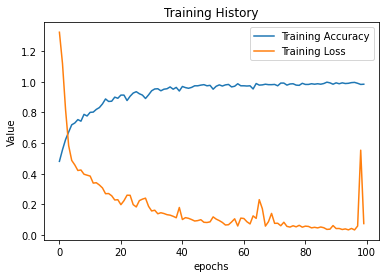

Initial training accuracy with preprocessing is:  0.48076921701431274
Final training accuracy with preprocessing is:  0.9837278127670288
Initial training loss with preprocessing is:  1.3225702047348022
Final training loss with preprocessing is:  0.07489924877882004


In [203]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

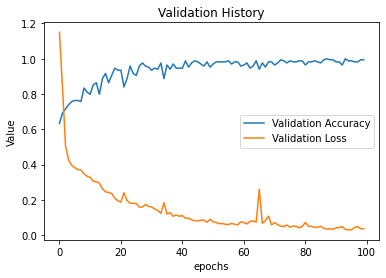

Initial Validation accuracy is:  0.6331360936164856
Best Validation accuracy is:  1.0
Initial Validation loss is:  1.1502865552902222
Best Validation loss is:  0.029804404824972153


In [204]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))